In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
etf_list = ['VTI','VEA', 'VWO', 'VNQ', 'XLE', 'BND', 'SCHP', 'VTEB', 'VIG']
pickle_list = []
for etf in etf_list:
    pickle_name = etf + '.pickle'
    pickle_list.append(pickle_name)

In [3]:
df_list = []
for etf in pickle_list:
    df_name = 'df_' + etf[0:2]
    df_name = pd.read_pickle(etf)
    df_list.append(df_name)

In [7]:
close_ls = []
for df in df_list:
    close_ls.append(df['close'])
stocks = pd.concat(close_ls,axis=1)
stocks.columns = ['VTI','VEA', 'VWO', 'VNQ', 'XLE', 'BND', 'SCHP', 'VTEB', 'VIG']

In [8]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,VTI,VEA,VWO,VNQ,XLE,BND,SCHP,VTEB,VIG
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001120,-0.000716,-0.000728,0.006988,-0.014195,-0.001341,-0.003416,-0.000775,0.001391
2,0.001757,-0.001433,0.001941,-0.002404,-0.002925,-0.000732,-0.000180,-0.001164,0.000535
3,-0.000798,-0.003591,-0.006811,0.006956,0.023767,-0.000855,-0.001622,-0.001165,0.001922
4,-0.000160,-0.003122,-0.003668,0.008924,0.007051,-0.000244,-0.001264,-0.000777,0.000746


In [9]:
num_ports = 20000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    weights = np.array(np.random.random(9))
    weights = weights / np.sum(weights)
    all_weights[ind, :] = weights
    
    ret_arr[ind] = np.sum((log_ret.mean()*weights)*252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [10]:
m = sharpe_arr.argmax()
max_sr_ret = ret_arr[m]
max_sr_vol = vol_arr[m]

In [11]:
all_weights[m,:]

array([0.08758857, 0.00941104, 0.01669848, 0.05712972, 0.01116774,
       0.18314738, 0.028193  , 0.26935845, 0.33730561])

In [12]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [13]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [14]:
def check_sum(weights):
    return np.sum(weights) - 1

In [15]:
def check_sum_eq(weights):
    return np.sum(weights[0:4]) - 0.9

In [16]:
cons = ({'type':'eq', 'fun': check_sum}, {'type':'eq','fun': check_sum_eq})

In [17]:
bounds = ((0,.5),(0,.5),(0,.5),(0,.5),(0,0.5),(0,.5),(0,.5),(0,.5),(0,.5))

In [18]:
init_guess = [(1/9),(1/9),(1/9),(1/9),(1/9),(1/9),(1/9),(1/9),(1/9)]

In [19]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [20]:
opt_results

     fun: -0.5085515975268233
     jac: array([-0.09375156,  0.51649803,  0.53247943,  0.18897194,  0.80087049,
       -0.00991769, -0.02535657, -0.10569939, -0.28712991])
 message: 'Optimization terminated successfully.'
    nfev: 22
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([5.00000000e-01, 0.00000000e+00, 9.15933995e-16, 4.00000000e-01,
       0.00000000e+00, 1.66533454e-16, 0.00000000e+00, 2.49800181e-16,
       1.00000000e-01])

In [21]:
opt_results.x

array([5.00000000e-01, 0.00000000e+00, 9.15933995e-16, 4.00000000e-01,
       0.00000000e+00, 1.66533454e-16, 0.00000000e+00, 2.49800181e-16,
       1.00000000e-01])

In [22]:
get_ret_vol_sr(opt_results.x)

array([0.06154364, 0.1210175 , 0.5085516 ])

In [23]:
frontier_y = np.linspace(0,0.05,10)

In [24]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [25]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
           {'type':'eq','fun':lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

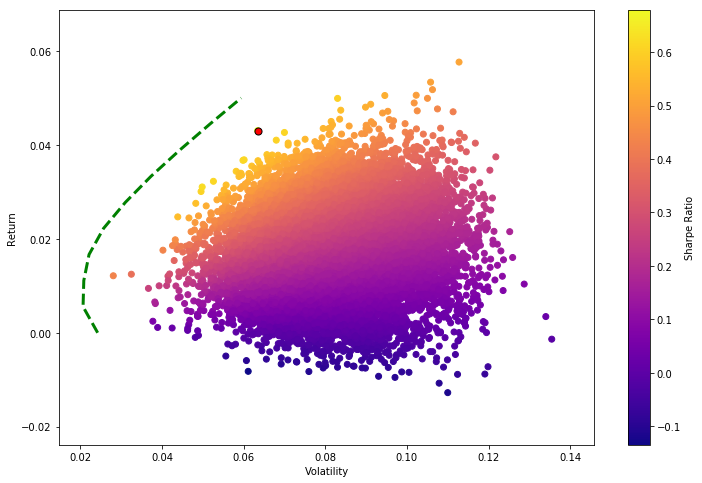

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)